# Design Patterns with LangGraph

## 🧠 Introduction to LangGraph

**LangGraph** is a powerful framework built on top of **LangChain** that helps developers design **stateful, multi-step AI applications** using **graph-based workflows**.

Instead of writing sequential chains or complex agents manually, LangGraph allows us to represent LLM logic as a **graph of nodes** — where:
- Each **node** represents a computation or decision step.
- **Edges** define how data flows between nodes.
- The entire graph maintains **state** throughout the conversation.

Think of LangGraph as:
> "A framework that brings deterministic control to agentic workflows powered by LLMs."

It blends the flexibility of traditional agents with the **reliability and observability** of a flow-based architecture.


====================================================================================================================================================================================
====================================================================================================================================================================================

## 💡 LangGraph – Theoretical Examples

### 🧭 Example 1: Simple RAG Workflow
A basic Retrieval-Augmented Generation (RAG) graph can have three nodes:

1. **Query Analyzer Node** – decides if the question needs retrieval.  
2. **Retriever Node** – fetches documents from the vector store.  
3. **Answer Generator Node** – uses the LLM to synthesize an answer.

**Flow:**  
User Query ➜ Query Analyzer ➜ Retriever ➜ Answer Generator ➜ Response

This gives fine control: if a query doesn’t need retrieval, the graph can skip the retriever step.

---

### 🧩 Example 2: FAQ Chatbot with Guardrails
For a PDF FAQ bot:
- **Input Node:** takes user question.  
- **Retriever Node:** fetches relevant chunks from the document.  
- **Answer Node:** LLM generates a summary answer.  
- **Verifier Node:** double-checks if the answer is grounded in source documents.  
- **Fallback Node:** returns “I’m not sure” if confidence < threshold.

This ensures reliability and factual accuracy.
---

✅ **Key takeaway**
LangGraph = *Visual + Deterministic + Stateful AI Flow Control.*

You can visualize it as:

====================================================================================================================================================================================
====================================================================================================================================================================================

## ⚙️ Why LangGraph?

When building RAG or agent-based systems with LLMs, we often face key challenges:

| Problem | Traditional Approach | LangGraph Advantage |
|----------|----------------------|----------------------|
| Complex agent logic | Hard to manage in sequential chains | Graph-based visual and modular design |
| Lack of state | Each call starts fresh | Persistent state throughout the graph |
| Limited control | LLMs decide all routes dynamically | You define deterministic flow between nodes |
| Debugging issues | No visibility into inner steps | Built-in observability and Langfuse integration |
| Maintenance overhead | Difficult to scale or modify | Nodes are reusable and composable |

In short:
- LangGraph gives **structured control** to AI workflows.
- It enables **human-in-the-loop**, **conditional routing**, and **parallel execution** easily.
- Perfect for building **Agentic RAG**, **multi-agent systems**, and **tool-using AI apps**.

🧩 **When to use LangGraph**
- You need more than a simple `LLMChain`.
- You want to orchestrate multiple components (retriever, re-ranker, answer generator, evaluator, etc.).
- You want to track or replay steps during debugging or fine-tuning.

====================================================================================================================================================================================
====================================================================================================================================================================================

In [6]:
import operator
from typing import Annotated, Literal
from typing_extensions import TypedDict
from pydantic import BaseModel

from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.prebuilt import ToolNode
from langgraph.graph.message import add_messages
from langgraph.types import Command

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import AnyMessage, HumanMessage, SystemMessage
from dotenv import load_dotenv

load_success = load_dotenv()

## Prompt Chaining

In [7]:
# Define LLM client
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
)

SYSTEM_INSTRUCTION=SystemMessage(content="""You are an expert technical writer. Always give clear,
     concise, and straight-to-the-point answers.""")

# Define the graph state
class State(dict):
    text: str
    topics: str
    title: str

# Define nodes (steps)
def extract_topics(state: State) -> State:
    prompt = [SYSTEM_INSTRUCTION, HumanMessage(content=f"Extract 1-3 key topics from the following text:\n\n{state['text']}")]
    resp = llm.invoke(prompt)
    state["topics"] = resp.content.strip()
    return state

def generate_title(state: State) -> State:
    prompt = [SYSTEM_INSTRUCTION, HumanMessage(content=f"Generate two catchy blog titles for each one these topics:\n\n{state['topics']}")]
    resp = llm.invoke(prompt)
    state["title"] = resp.content.strip()
    return state

# Build the graph
workflow = StateGraph(State)
workflow.add_node("extract_topics", extract_topics)
workflow.add_node("generate_title", generate_title)

# Flow: extract_topics → generate_title → END
workflow.set_entry_point("extract_topics")
workflow.add_edge("extract_topics", "generate_title")
workflow.add_edge("generate_title", END)

# Compile runnable graph
graph = workflow.compile()

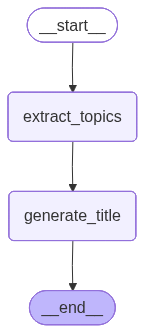

In [8]:
graph

In [9]:
# Run the graph
input_text = (
    "LangGraph introduces a graph-based paradigm for building LLM-powered agents. "
    "It allows developers to create modular, debuggable, and reliable agent workflows "
    "using nodes, edges, and state passing."
)

result = graph.invoke({"text": input_text})
print("Topics:", result["topics"])
print("\n"+"="*50+"\n")
print("Suggested Blog Title:", result["title"])

Topics: *   **Graph-based agent workflows:** LangGraph uses graphs as the foundation for agent design.
*   **Modularity and debuggability:** LangGraph promotes modular and easy-to-debug agent construction.


Suggested Blog Title: Okay, here are two catchy blog titles for each topic:

**Graph-based agent workflows:**

1.  **Agent Unleashed: Building Smarter Workflows with LangGraph**
2.  **Beyond Chains: Graph-Powered Agents for Complex Tasks**

**Modularity and debuggability:**

1.  **No More Agent Chaos: LangGraph's Modular Approach to Debugging**
2.  **Agent Development Simplified: How LangGraph Makes Debugging a Breeze**


## Routing

In [10]:
# LLM client
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
)

SYSTEM_INSTRUCTION=SystemMessage(content="""You are a helpful assistant that can classify text
    sentiment and respond accordingly.""")

# State definition
class State(dict):
    text: str
    sentiment: str
    response: str

# Nodes
def calssification(state: State) -> str:
    """Classify sentiment."""
    prompt = [SYSTEM_INSTRUCTION, HumanMessage(content=f"Is the following text positive or negative? Answer with one word only: Positive or Negative.\n\n{state['text']}")]
    resp = llm.invoke(prompt)
    sentiment = resp.content.strip().lower()
    state["sentiment"] = sentiment
    return state

def positive_node(state: State) -> State:
    prompt = [SYSTEM_INSTRUCTION, HumanMessage(content=f"Generate an encouraging reply to this positive text:\n\n{state['text']}")]
    resp = llm.invoke(prompt)
    state["response"] = resp.content.strip()
    return state

def negative_node(state: State) -> State:
    prompt = [SYSTEM_INSTRUCTION, HumanMessage(content=f"Generate a supportive reply to this negative text:\n\n{state['text']}")]
    resp = llm.invoke(prompt)
    state["response"] = resp.content.strip()
    return state

def router_func(state: State) -> Literal["positive", "negative"]:
    """Return next node name."""
    return "positive" if "positive" in state["sentiment"] else "negative"

# Build the graph
workflow = StateGraph(State)

workflow.add_node("calssification", calssification)
workflow.add_node("positive", positive_node)
workflow.add_node("negative", negative_node)

# classify node decides the next step
workflow.set_entry_point("calssification")
workflow.add_conditional_edges("calssification", router_func, {
    "positive": "positive",
    "negative": "negative",
})

# Both branches lead to END
workflow.add_edge("positive", END)
workflow.add_edge("negative", END)

graph = workflow.compile()

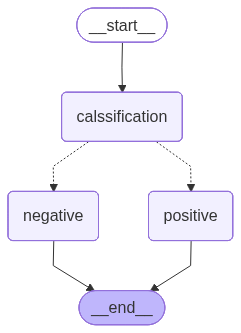

In [11]:
graph

In [12]:
# Run example
input_text = "I'm so sad with how my project turned out!"
result = graph.invoke({"text": input_text})
print("Sentiment:", result["sentiment"])
print("Response:", result["response"])

Sentiment: negative
Response: Okay, I understand you're feeling sad about how your project turned out. That's completely valid and it's okay to feel disappointed when things don't go as planned.

Before you get too down, remember that every project is a learning experience. Even if the outcome isn't what you hoped for, there's likely valuable knowledge you've gained along the way.

Would you like to talk about what specifically you're unhappy with? Sometimes just breaking it down can help. Or, if you'd rather just vent, I'm here to listen.

Remember, one project doesn't define you. You've got this! And I'm here to offer support if you need it.


## Parallelization

In [13]:
# LLM client
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
)

# State definition
class State(TypedDict):
    text: str
    # Reducer makes these append-only so multiple nodes can update in parallel
    outputs: Annotated[list, operator.add]

# Nodes
def summarize(state: State):
    prompt = f"Summarize in one sentence:\n\n{state['text']}"
    resp = llm.invoke(prompt)
    return {"outputs": [f"Summary: {resp.content.strip()}"]}

def critique(state: State):
    prompt = f"Critique briefly:\n\n{state['text']}"
    resp = llm.invoke(prompt)
    return {"outputs": [f"Critique: {resp.content.strip()}"]}

def combine(state: State):
    prompt = f"Combine the following Critique and Summarization in one \
    paragraph:\n\n{state['text']}"
    resp = llm.invoke(prompt)
    return {"outputs": [f"Combined:\n{resp.content.strip()}"]}

# Build the graph
builder = StateGraph(State)
builder.add_node("summarize", summarize)
builder.add_node("critique", critique)
builder.add_node("combine", combine)

# Parallel edges: summarize and critique run side by side
builder.add_edge(START, "summarize")
builder.add_edge(START, "critique")

# Both join into combine
builder.add_edge("summarize", "combine")
builder.add_edge("critique", "combine")

builder.add_edge("combine", END)

graph = builder.compile()

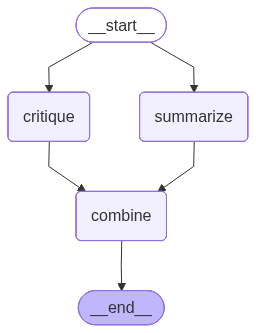

In [14]:
graph

In [15]:
# --- Run example ---
input_text = "LangGraph helps developers design and run agent workflows with LLMs."
result = graph.invoke({"text": input_text, "outputs": []})

print("\nFinal outputs:")
for out in result["outputs"]:
    print(out)
    print("="*100 + "\n")


Final outputs:
Critique: The statement is accurate but lacks detail. Here's a brief critique:

**Strengths:**

*   **Accurate:** It correctly identifies LangGraph's core function.
*   **Concise:** It's a short and easily digestible description.

**Weaknesses:**

*   **Vague:** It doesn't specify *how* LangGraph helps. What makes it different from other LLM workflow tools?
*   **Missing key benefits:** It doesn't highlight benefits like structured workflows, state management, or the ability to create complex, multi-agent systems.
*   **Doesn't target the *why*:** Why would a developer *choose* LangGraph over other options?

**In short:** The statement is a good starting point, but it needs more detail to be truly informative and compelling.

Summary: LangGraph is a framework for building multi-agent workflows driven by large language models.

Combined:
LangGraph streamlines the process of building agent workflows powered by large language models (LLMs), offering a framework for develop

## Reflection

In [16]:
# LLM client
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
)

# State
class State(TypedDict):
    task: str
    draft: str
    feedback: str
    final: str

# Nodes
def generator(state: State):
    """Generate an initial or refined draft."""
    prompt = f"""
You are an assistant helping to complete the following task:

Task:
{state['task']}

Current Draft:
{state.get('draft', 'None')}

Feedback:
{state.get('feedback', 'None')}

Instructions:
- If there is no draft and no feedback, generate a clear and complete response to the task.
- If there is a draft but no feedback, improve the draft as needed for clarity and quality.
- If there is both a draft and feedback, revise the draft by incorporating the feedback directly.
- Always produce a single, improved draft as your output.
"""
    resp = llm.invoke(prompt)
    return {"draft": resp.content.strip()}

def evaluator(state: State):
    """Evaluate the draft and give feedback or approval."""
    prompt = f"""Evaluate the following draft, based on the given task.
If it meets the requirements, reply exactly 'APPROVED'.
Otherwise, provide constructive feedback for improvement.
Task:
{state['task']}
Draft:
{state['draft']}"""
    resp = llm.invoke(prompt)
    print(f"""
================= DRAFT =================
{state['draft']}

================ FEEDBACK ===============
{resp.content.strip()}
========================================
""")
    return {"feedback": resp.content.strip()}

def decide(state: State) -> str:
    """Decide next step: either approve and finish, or refine again."""
    if "APPROVED" in state["feedback"].upper():
        return "approved"
    return "refine"

def finalize(state: State):
    """Save the final approved draft."""
    return {"final": state["draft"]}

# Build the graph
builder = StateGraph(State)

builder.add_node("generator", generator)
builder.add_node("evaluator", evaluator)
builder.add_node("finalize", finalize)

builder.add_edge(START, "generator")
builder.add_edge("generator", "evaluator")
builder.add_edge("evaluator", "finalize")

# Conditional edges from decide
builder.add_conditional_edges(
    "evaluator",
    decide,
    {
        "approved": "finalize",   # stop loop
        "refine": "generator",    # go back for improvement
    },
)

builder.add_edge("finalize", END)

graph = builder.compile()

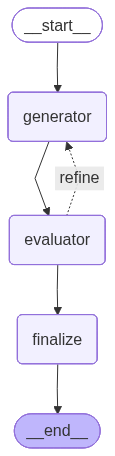

In [17]:
graph

In [18]:
# Run example
input_task = "You have six horses and want to race them to see which is fastest. What is the best way to do this?"
result = graph.invoke({"task": input_task})

print("\nFinal Answer:\n", result["final"])


================= DRAFT =================
Here's a strategy to determine the fastest horse among six, assuming you can only race a subset of them at a time and don't have a way to measure their individual times:

1. **Initial Races:** Divide the six horses into two groups of three (Group A and Group B). Race Group A and then race Group B.

2. **Identify Potential Fastest:**  Let's say the horses in Group A finished A1, A2, A3 (A1 being the fastest in that race), and the horses in Group B finished B1, B2, B3.  The *only* horses that have a chance to be the absolute fastest are A1 and B1.

3. **The Decisive Race:** Race A1 and B1 against each other. The winner of this race is the fastest horse overall.

**Explanation:**

*   By running the initial races, you narrow down the possibilities significantly. Horses that finished second or third in their initial races cannot be the overall fastest.
*   The final race directly compares the fastest horses from each initial group. This determines

## Tool Use

In [19]:
# State definition
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

# Define a simple tool
def calculator(expression: str):
    """Evaluate a math expression."""
    try:
        return str(eval(expression))
    except Exception as e:
        return f"Error: {e}"

# Initialize Gemini model with tools
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
)

model_with_tools = llm.bind_tools([calculator])
tool_node = ToolNode([calculator])

# Nodes
def call_model(state: State):
    """Call the model; it may request a tool."""
    messages = state["messages"]
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}

def should_continue(state: State):
    """Decide whether to go to tools or finish."""
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:  # If the model requested a tool
        return "tools"
    return END

# Build the graph
builder = StateGraph(State)

builder.add_node("call_model", call_model)
builder.add_node("tools", tool_node)

builder.add_edge(START, "call_model")
builder.add_conditional_edges("call_model", should_continue, ["tools", END])
builder.add_edge("tools", "call_model")

graph = builder.compile()

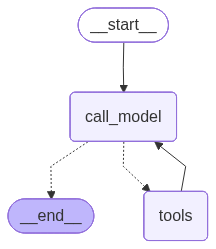

In [20]:
graph

In [21]:
# Run example
query = {"role": "user", "content": "What is 12 * 7?"}
result = graph.invoke({"messages": [query]})

print("\nConversation:")
for m in result["messages"]:
    print(m)


Conversation:
content='What is 12 * 7?' additional_kwargs={} response_metadata={} id='1ccd963b-c42a-491a-8650-e21e4226e538'
content='' additional_kwargs={'function_call': {'name': 'calculator', 'arguments': '{"expression": "12 * 7"}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': [], 'grounding_metadata': {}, 'model_provider': 'google_genai'} id='lc_run--1c0b3a28-620b-4d5c-8bbf-52fa8c41d76b-0' tool_calls=[{'name': 'calculator', 'args': {'expression': '12 * 7'}, 'id': '57843281-9116-4280-ae20-66d2c4c7d846', 'type': 'tool_call'}] usage_metadata={'input_tokens': 19, 'output_tokens': 7, 'total_tokens': 26, 'input_token_details': {'cache_read': 0}}
content='84' name='calculator' id='0f20fb93-f627-4e27-91ff-f8a015523d8e' tool_call_id='57843281-9116-4280-ae20-66d2c4c7d846'
content='The answer is 84.' additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 's

## Planning

Simulated workers and response for brevity, but in real application, workers would be react agents or more complex workflows.

The key difference from Routing is that the Planner generates a multi-step plan rather than selecting a single next step.

In [22]:
# Set up the Language Model
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
)

# Define the State
# We need separate fields for each worker's results.
class PlannerState(TypedDict):
    task: str
    plan: list[str]
    graphql_results: str  # Results from the GraphQL researcher
    rest_results: str     # Results from the REST researcher
    final_output: str     # The final written summary

# Define the Tools and Workers

# Dummy tools for our researchers
def graphql_search_tool(query: str):
    """A dummy tool that returns fixed info about GraphQL."""
    print(f"GRAPHQL RESEARCHER: Searching for '{query}'")
    return "GraphQL Pros: Efficient data fetching (no over-fetching), single endpoint, strongly typed schema."

def rest_search_tool(query: str):
    """A dummy tool that returns fixed info about REST."""
    print(f"REST RESEARCHER: Searching for '{query}'")
    return "REST API Cons: Can lead to over or under-fetching data, requires multiple round-trips for complex queries, URL-based structure can be rigid."

# Worker Nodes
def graphql_research_worker(state: PlannerState):
    """Worker node that researches GraphQL pros."""
    results = graphql_search_tool("pros of GraphQL")
    return {"graphql_results": results}

def rest_research_worker(state: PlannerState):
    """Worker node that researches REST cons."""
    results = rest_search_tool("cons of REST APIs")
    return {"rest_results": results}

def writer_worker(state: PlannerState):
    """
    Synthesizer node that waits for all research and writes the final output.
    This node acts as the "join" point.
    """
    print("WRITER: Synthesizing results")
    graphql_results = state['graphql_results']
    rest_results = state['rest_results']

    writing_prompt = f"""
    Write a short, balanced comparison post based on the following research.

    GraphQL Information:
    {graphql_results}

    REST API Information:
    {rest_results}
    """
    response = llm.invoke(writing_prompt)
    return {"final_output": response.content}

# Define the Planner
def planner(state: PlannerState):
    """Planner node that creates the initial plan."""
    print("PLANNER: Creating a plan for parallel execution")
    # For this example, the plan is hardcoded.
    # In a real app, an LLM would generate this based on the task.
    plan = [
        "Research GraphQL pros",
        "Research REST cons",
        "Write comparison post"
    ]
    return {"plan": plan}

# Build the Graph
workflow = StateGraph(PlannerState)

# Add the nodes
workflow.add_node("planner", planner)
workflow.add_node("graphql_researcher", graphql_research_worker)
workflow.add_node("rest_researcher", rest_research_worker)
workflow.add_node("writer", writer_worker)

# Set the entry point
workflow.set_entry_point("planner")

# Define the parallel edges
# After the planner, both research workers are called.
workflow.add_edge("planner", "graphql_researcher")
workflow.add_edge("planner", "rest_researcher")

# Define the join point
# The writer will only run after BOTH research workers are complete.
workflow.add_edge("graphql_researcher", "writer")
workflow.add_edge("rest_researcher", "writer")

# The graph ends after the writer is done
workflow.add_edge("writer", END)

# Compile the graph
graph = workflow.compile()

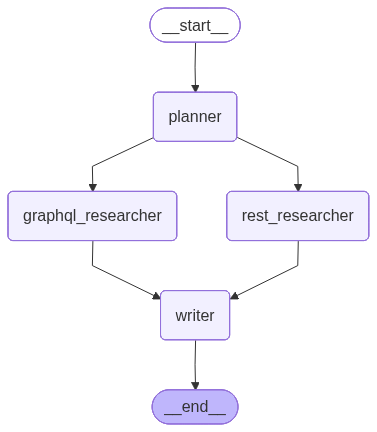

In [23]:
graph

In [24]:
# Run the Graph
user_task = "Write a short post comparing the pros of GraphQL with the cons of REST APIs."
initial_state = {"task": user_task}

# Stream the events to see the execution flow
for event in graph.stream(initial_state):
    for key, value in event.items():
        print(f"Node '{key}' output:")
        print("---")
        print(value)
        print("\n" + "="*30 + "\n")

# Get the final output
final_state = graph.invoke(initial_state)
print("Final Comparison Post:")
print(final_state['final_output'])

PLANNER: Creating a plan for parallel execution
Node 'planner' output:
---
{'plan': ['Research GraphQL pros', 'Research REST cons', 'Write comparison post']}


GRAPHQL RESEARCHER: Searching for 'pros of GraphQL'
Node 'graphql_researcher' output:
---
{'graphql_results': 'GraphQL Pros: Efficient data fetching (no over-fetching), single endpoint, strongly typed schema.'}


REST RESEARCHER: Searching for 'cons of REST APIs'
Node 'rest_researcher' output:
---
{'rest_results': 'REST API Cons: Can lead to over or under-fetching data, requires multiple round-trips for complex queries, URL-based structure can be rigid.'}


WRITER: Synthesizing results
Node 'writer' output:
---
{'final_output': "## GraphQL vs. REST APIs: A Quick Comparison\n\nChoosing the right API architecture is crucial for any application. Two popular choices are GraphQL and REST APIs, each with its own strengths and weaknesses.\n\n**GraphQL shines with its efficiency.** By allowing clients to request only the data they need,

## Multi-agent

In this example, we will use the `Command` Class instead of conditional edges, just to showcase that we can both update the graph state and route to a different node simultaniously.
This is very useful when desining complex multi-agent architectures.


In [25]:
# Set up the Language Model
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
)

# Define the Supervisor's Routing Logic

# This Pydantic model helps the supervisor choose the next agent.
class Router(BaseModel):
    """Decide the next agent to route to."""
    next_agent: Literal["Weather", "Flights", "__end__"]

# Bind the router to the model to get structured output.
supervisor_model = llm.with_structured_output(Router)

def supervisor(state: MessagesState) -> Command:
    """
    The central supervisor that routes to the correct agent or ends the conversation.
    """
    print("--- 🧑‍💼 SUPERVISOR ---")

    # The prompt tells the supervisor how to route the user's message.
    prompt = f"""You are a supervisor routing tasks to a specialist agent.
    Based on the user's request, choose the appropriate agent.

    Available agents:
    - Weather: For questions about weather forecasts.
    - Flights: For questions about flight information.

    If the user is saying thank you or the conversation is over, choose '__end__'.

    User message: "{state['messages'][-1].content}"
    """
    if isinstance(state['messages'][-1], HumanMessage):
      # The supervisor model makes the routing decision.
      response = supervisor_model.invoke(prompt)
      print(f"Supervisor routing to: {response.next_agent}")
      return Command(goto=response.next_agent)
    else:
      return Command(goto='__end__')

# Define the Specialist Agents

def weather_agent(state: MessagesState) -> Command:
    """A specialist agent for handling weather-related queries."""
    print("--- ☀️ WEATHER AGENT ---")

    prompt = f"""You are a weather forecaster. Provide a concise mock weather forecast
    for the location mentioned in the user's message.

    User message: "{state['messages'][-1].content}"
    """
    response = llm.invoke(prompt)
    print(f"Response: {response.content}")
    # Return to the supervisor after the agent has run.
    return Command(
        goto="supervisor",
        update={"messages": [response]},
    )

def flights_agent(state: MessagesState) -> Command:
    """A specialist agent for handling flight-related queries."""
    print("--- ✈️ FLIGHTS AGENT ---")

    prompt = f"""You are a flight information assistant. Provide some mock flight
    details for the destination in the user's message. Respond with short concise information.

    User message: "{state['messages'][-1].content}"
    """
    response = llm.invoke(prompt)
    print(f"Response: {response.content}")
    # Return to the supervisor after the agent has run.
    return Command(
        goto="supervisor",
        update={"messages": [response]},
    )

# Build the Graph

builder = StateGraph(MessagesState)

# Add the supervisor and agents as nodes in the graph.
builder.add_node("supervisor", supervisor)
builder.add_node("Weather", weather_agent)
builder.add_node("Flights", flights_agent)

# The START node directs the flow to the supervisor first.
builder.add_edge(START, "supervisor")

# The graph is now complete. The `Command` objects will handle the dynamic routing.
graph = builder.compile()

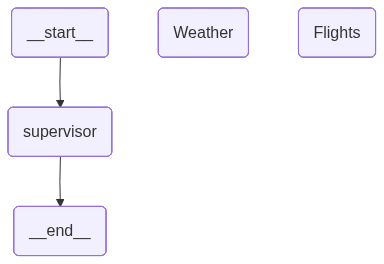

In [26]:
graph

In [27]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break

    # The graph.stream() method invokes the graph and streams the results.
    events = graph.stream({"messages":[HumanMessage(content=user_input)]})
    for event in events:
        # We only print the AI's responses to the user.
        if "messages" in event:
            event["messages"][-1].pretty_print()

--- 🧑‍💼 SUPERVISOR ---
Supervisor routing to: Weather
--- ☀️ WEATHER AGENT ---
Response: Okay, here's your weather forecast for Chennai:

**Today:** Partly sunny with a high of 32°C. Chance of isolated showers, mainly in the afternoon. Light winds from the northeast.

**Tonight:** Mostly clear with a low of 26°C.
--- 🧑‍💼 SUPERVISOR ---
Goodbye!
